<a href="https://colab.research.google.com/github/duychan/text_classifier/blob/dev/my_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

C
: hằng số dương giúp cân đối độ lớn của margin và sự hy sinh của các điểm nằm trong vùng không an toàn. Khi 
C
=
∞
 hoặc rất lớn, Soft Margin SVM trở thành Hard Margin SVM.

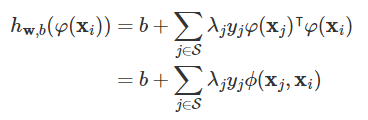

---
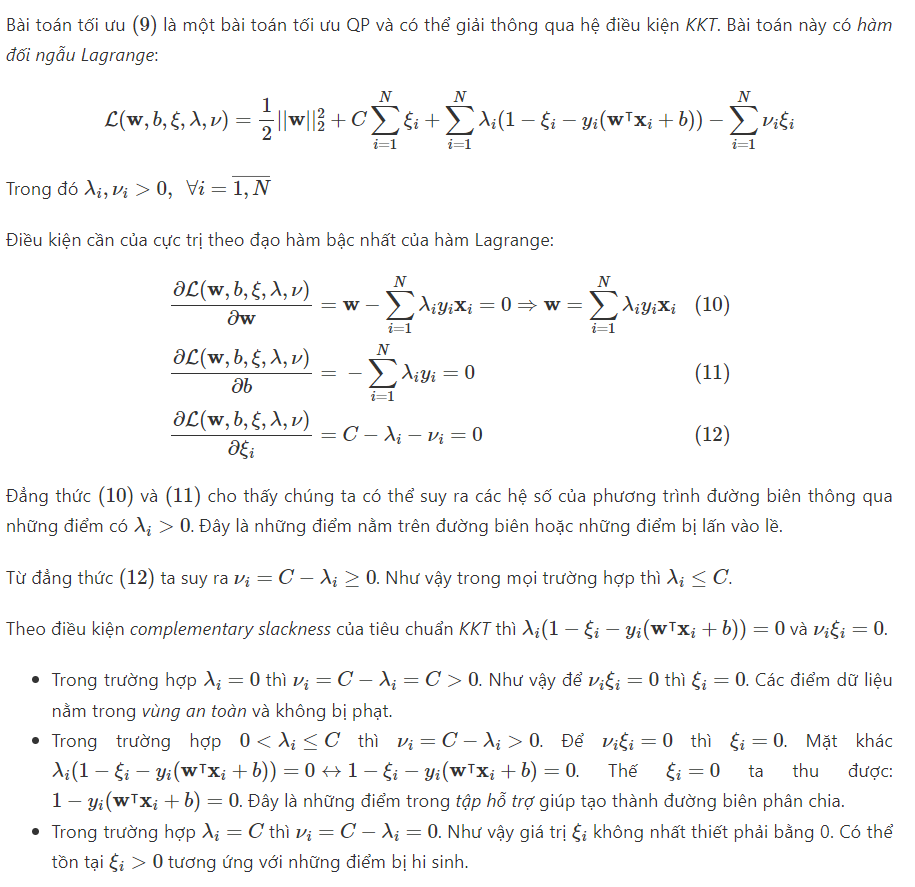



In [ ]:
!cp /content/drive/MyDrive/ML/CuoiKi/Mape_MSE.py /content

In [ ]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=0.1):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(-np.ones((n_samples,1)))
        A = cvxopt.matrix(y, (1,n_samples), "d")
        b = cvxopt.matrix(np.zeros(1))

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples)*-1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G = cvxopt.matrix(np.vstack((np.eye(n_samples)*-1,np.eye(n_samples))))
            h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples)*self.C)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])
        print("a: ",a)
        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("a': %f, sv: %f, sv_y: %f" % self.a, self.sv, self.sv_y)
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
            print("b: ",b)
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/ML/ktkh.csv")#("/content/drive/MyDrive/ML/news_clean_2.csv")#("/content/drive/MyDrive/ML/final_dataset_2.csv")
data = data[["Content_processed", "label"]].dropna()

In [ ]:
data.head()

,Content_processed,label
0,nội_dung đề_cập dự_thảo thông_tư hướng_dẫn chi...,kinhte
1,số_liệu đại_diện sở kế_hoạch đầu_tư thành_phố ...,kinhte
2,báo_cáo dkra việt_nam 10 giá_bán căn_hộ thị_tr...,kinhte
3,là tỷ_phú quá_cố dietrich_mateschitz mark thừa...,kinhte
4,hiện đất tổng diện_tích 550 m2 hai mặt tiền đư...,kinhte


In [ ]:
X = data["Content_processed"]
Y = data["label"]

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["kinhte", "khoahoc"])
Y = le.transform(Y)
Y[Y == 1] = 1
Y[Y == 0] = -1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=41)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 2)
tf_idf = vectorizer.fit_transform(X_train)
tf_idf.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.01919771, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.03864069, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.0212392 , 0.        , ..., 0.17024254, 0.        ,
         0.        ]])

In [ ]:
dense_array = np.array(tf_idf.todense())

In [ ]:
tf_idf_test_set = vectorizer.transform(X_test)
dense_array_test_set = np.array(tf_idf_test_set.todense())

In [ ]:
dense_array.shape, dense_array_test_set.shape, Y_train.shape, Y_test.shape

((728, 7050), (313, 7050), (728,), (313,))

In [ ]:

import numpy as np

def linear_kernel(**kwargs):
    def f(x1, x2):
        return np.inner(x1, x2)
    return f


def polynomial_kernel(power, coef, **kwargs):
    def f(x1, x2):
        return (np.inner(x1, x2) + coef)**power
    return f


def rbf_kernel(gamma, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)
    return f
# Hide cvxopt output
cvxopt.solvers.options['show_progress'] = False

class SupportVectorMachine(object):
    """The Support Vector Machine classifier.
    Uses cvxopt to solve the quadratic optimization problem.
    Parameters:
    -----------
    C: float
        Penalty term.
    kernel: function
        Kernel function. Can be either polynomial, rbf or linear.
    power: int
        The degree of the polynomial kernel. Will be ignored by the other
        kernel functions.
    gamma: float
        Used in the rbf kernel function.
    coef: float
        Bias term used in the polynomial kernel function.
    """
    def __init__(self, C=10, kernel=linear_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y):

        n_samples, n_features = np.shape(X)

        # Set gamma to 1/n_features by default
        if not self.gamma:
            self.gamma = 1 / n_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        # Calculate kernel matrix
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])

        # Define the quadratic optimization problem
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))

        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lagr_mult = np.ravel(minimization['x'])
        # Get indexes of non-zero lagr. multipiers
        idx = (lagr_mult > 1e-7) & (lagr_mult < self.C)
        # Get the corresponding lagr. multipliers
        self.lagr_multipliers = lagr_mult[idx]
        # Get the samples that will act as support vectors
        self.support_vectors = X[idx]
        # Get the corresponding labels
        self.support_vector_labels = y[idx]
        # Calculate intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

In [ ]:
my_svm = SupportVectorMachine(C=10, kernel=rbf_kernel, gamma=0.01)
my_svm.fit(dense_array, Y_train)

In [ ]:
y_pred = my_svm.predict(dense_array_test_set)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("accuracy {}".format(round(accuracy_score(y_pred, Y_test), 3)))
confusion_matrix(y_pred, Y_test)

accuracy 0.981


array([[172,   6],
       [  0, 135]])

In [ ]:
from sklearn.svm import SVC
svm_lib = SVC(C=10, kernel="rbf", gamma=0.01)
svm_lib.fit(dense_array, Y_train)

SVC(C=10, gamma=0.01)

In [ ]:
from Mape_MSE import calculate_mape, calculate_mse
print("MAPE: {}, MSE: {}".format(calculate_mape(Y_test, y_pred), calculate_mse(y_pred, Y_test)))

MAPE: 3.834, MSE: 7.668


In [ ]:
y_pred_lib = svm_lib.predict(dense_array_test_set)

In [ ]:
print("accuracy {}".format(round(accuracy_score(y_pred_lib, Y_test), 3)))
confusion_matrix(y_pred_lib, Y_test)

accuracy 0.978


array([[167,   2],
       [  5, 139]])

In [ ]:
print("MAPE: {}, MSE: {}".format(calculate_mape(Y_test, y_pred_lib), calculate_mse(y_pred_lib, Y_test)))

MAPE: 4.473, MSE: 8.946
